Utilizing machine learning algorithms to generate trading signals aims to forecast market movements. These algorithms can classify the next day's market movement into three categories: market will rise (long position), market will fall (short position), or market will move sideways (no position). Knowing the market direction allows us to determine the best entry and exit points.

One significant challenge in cryptocurrency trading is market volatility. Given that cryptocurrency markets operate 24/7, continuously monitoring positions against rapidly changing dynamics can quickly become unmanageable. Automated trading algorithms and trading bots can provide crucial assistance in this regard

In [48]:

from pandas.plotting import scatter_matrix

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier

import warnings
warnings.filterwarnings('ignore')


Null Values = True


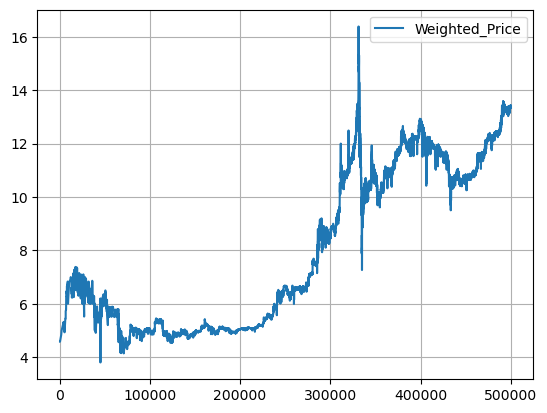

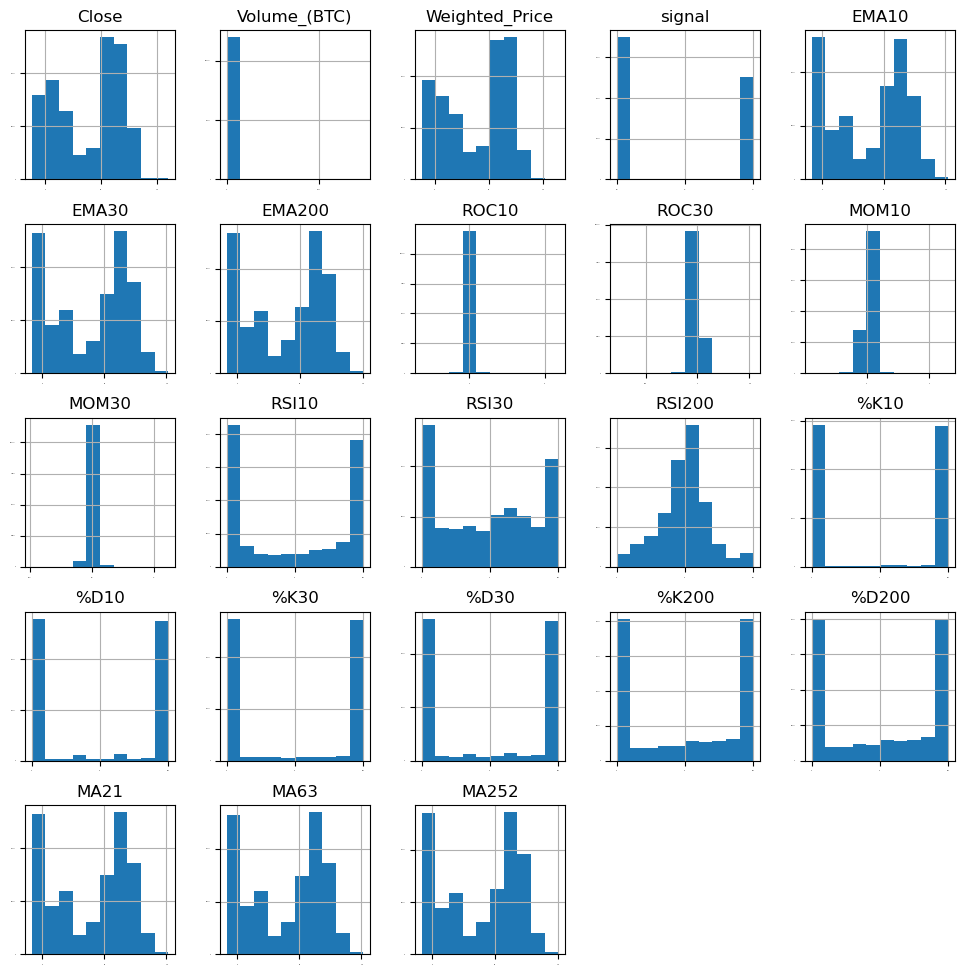

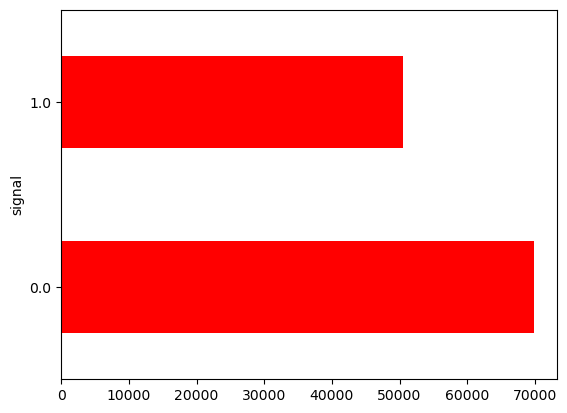

LR: 0.882400 (0.003678)
LDA: 0.874750 (0.002902)
KNN: 0.930913 (0.001866)
CART: 0.959538 (0.002060)
NB: 0.813413 (0.003050)
NN: 0.906500 (0.004404)
AB: 0.878800 (0.004502)
GBM: 0.905187 (0.003137)
RF: 0.967425 (0.002148)


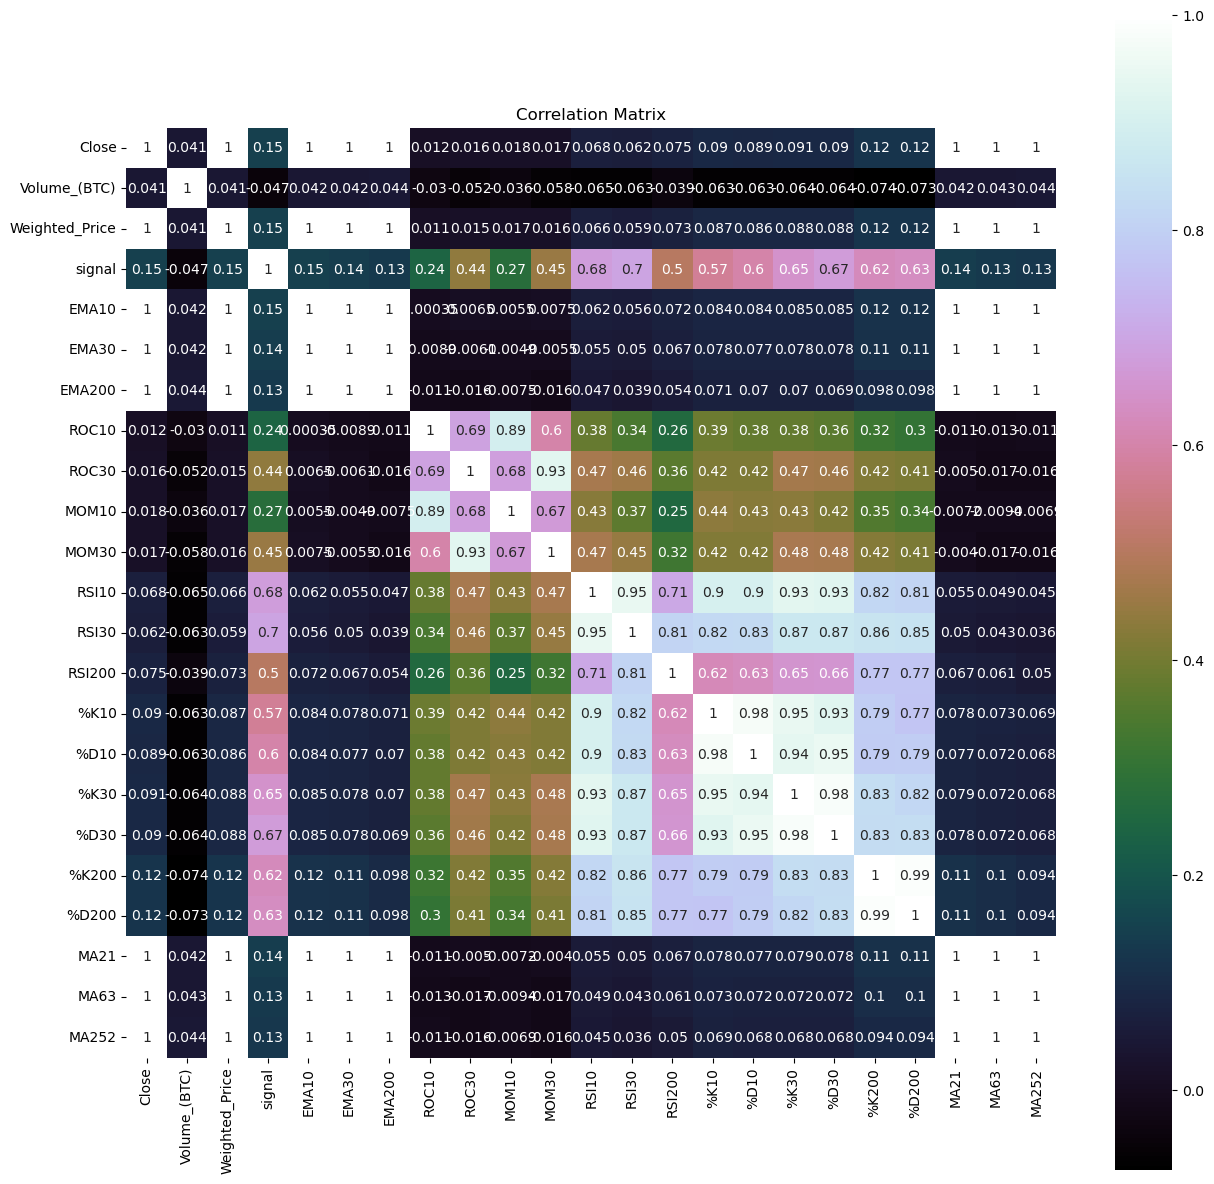

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, set_option
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
import warnings

warnings.filterwarnings('ignore')

# Load dataset
dataset = pd.read_csv('data.csv')
set_option('display.width', 100)

# Check for null values
print('Null Values =', dataset.isnull().values.any())

# Forward fill to handle null values
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

# Drop the 'Timestamp' column
dataset = dataset.drop(columns=['Timestamp'])

# Create short and long simple moving averages
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

# Exponential Moving Average (EMA)
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA

dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)

# Rate of Change (ROC)
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name='ROC_' + str(n))
    return ROC

dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

# Momentum (MOM)
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM

dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

# Relative Strength Index (RSI)
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period - 1]] = np.mean(u[:period])  # first value is sum of avg gains
    u = u.drop(u.index[:(period - 1)])
    d[d.index[period - 1]] = np.mean(d[:period])  # first value is sum of avg losses
    d = d.drop(d.index[:(period - 1)])
    rs = u.ewm(com=period - 1, adjust=False).mean() / d.ewm(com=period - 1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

# Stochastic Oscillator
def STOK(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

# Moving Average (MA)
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA

dataset['MA21'] = MA(dataset, 21)
dataset['MA63'] = MA(dataset, 63)
dataset['MA252'] = MA(dataset, 252)

# Drop unnecessary columns
dataset = dataset.drop(['High', 'Low', 'Open', 'Volume_(Currency)', 'short_mavg', 'long_mavg'], axis=1)
dataset = dataset.dropna(axis=0)

# Plotting
dataset[['Weighted_Price']].plot(grid=True)
plt.show()

# Histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12, 12))
plt.show()

# Bar plot of signal distribution
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

# Correlation matrix
correlation = dataset.corr()
plt.figure(figsize=(15, 15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

# Subset the dataset for training
subset_dataset = dataset.iloc[-100000:]
Y = subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']

# Split the data
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# Scale the data

# Set up models
num_folds = 10
seed = 7
scoring = 'accuracy'
models = []
models.append(('LR', LogisticRegression(n_jobs=-1, max_iter=1000, solver='lbfgs')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('NN', MLPClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    if name == 'LR':
        cv_results = cross_val_score(model, X_train_scaled, Y_train, cv=kfold, scoring=scoring)
    else:
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


In [50]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds,shuffle = True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.930388 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#6 0.882725 (0.002475) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#5 0.882750 (0.002558) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#2 0.928738 (0.002358) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#1 0.930388 (0.002729) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.877200 (0.004996) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#7 0.878688 (0.002418) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.923187 (0.003275) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#3 0.926050 (0.003399) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


In [51]:
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression() 
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [52]:
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9332
[[10265   662]
 [  674  8399]]
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     10927
         1.0       0.93      0.93      0.93      9073

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



<Axes: xlabel='Predicted', ylabel='Actual'>

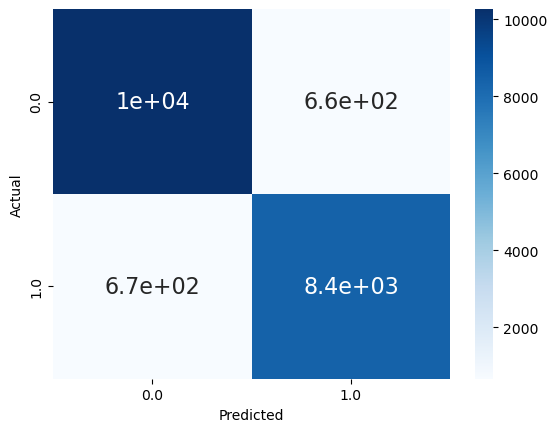

In [53]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

Text(0.5, 0, 'Variable Importance')

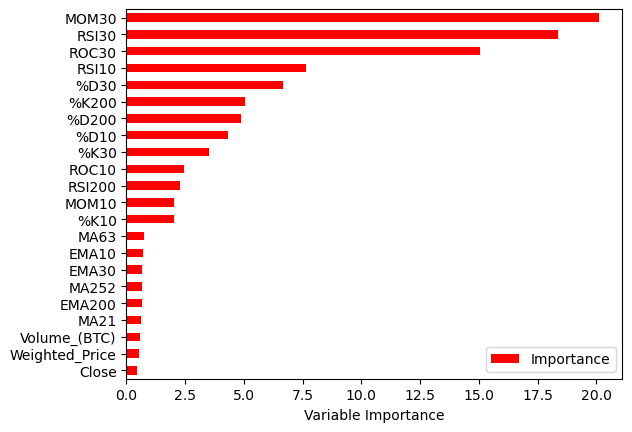

In [54]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

<Axes: >

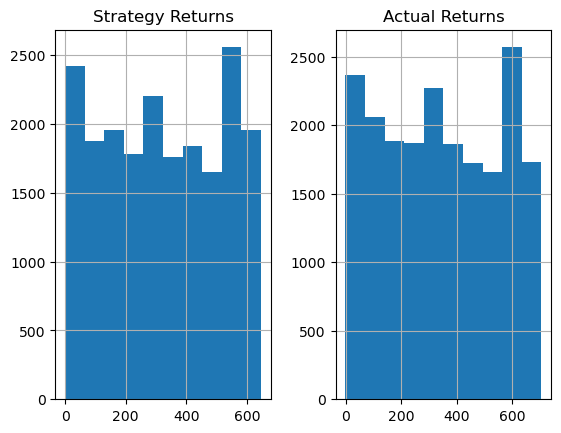

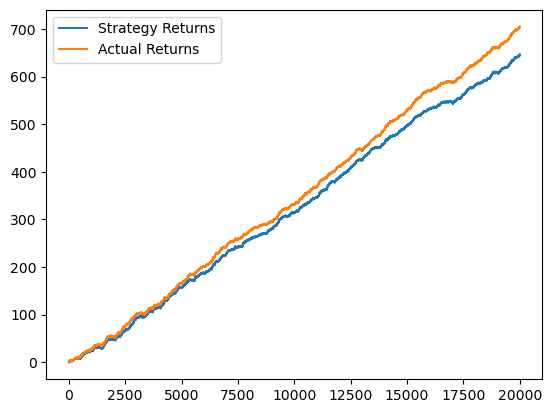

In [55]:
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()